In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

plt.rc('font', size=14)
plt.rc('lines', linewidth=3)

# Boosting Trees

```

```
##### Moses Marsh

##### Galvanize DSI


# Objectives
- Review regression trees and random forests
 - What is a strong learner and how do we deal with it?
- Introduce boosting
 - What is a weak learner and how can it be useful?
- Understand how a gradient boosting regressor works and how to tune one
- Introduce and step through the AdaBoost classifier algorithm
 

# Single Regression Tree
- The target $y$ is real-valued
- The predicted value for a node is the mean of the $y$ values in that node
- The impurity criterion is the mean squared error (variance) of the values
- Splits are made to maximize information gain

In [2]:
np.random.seed(138)
num_samp=300
x = np.linspace(0,5,num=num_samp)
y_ground = 2.5*np.sin(2*x) + x
y = y_ground + 0.8*np.random.normal(size=num_samp)
x = x.reshape(-1,1)

# Single Regression Tree: example

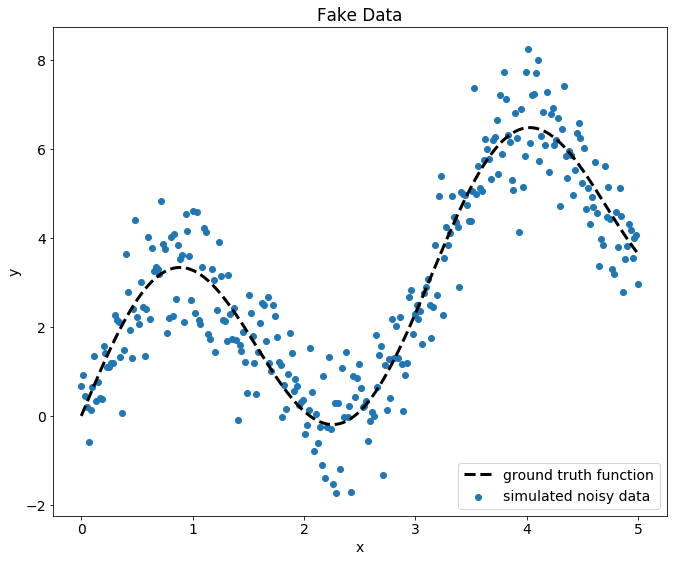

In [3]:

plt.figure(figsize=(11,9))
plt.scatter(x,y, label='simulated noisy data')
plt.plot(x, y_ground, 'k--', label='ground truth function')
plt.title('Fake Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right');

# Single Regression Tree: example

In [4]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(x,y);

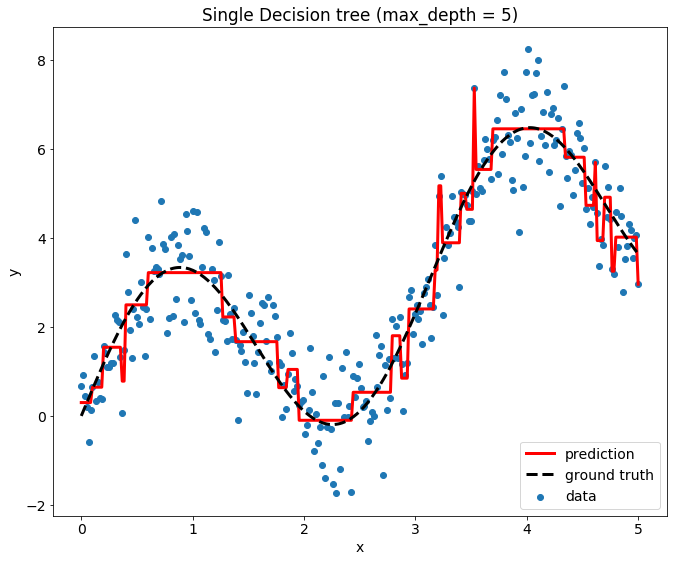

In [5]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,dt.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Single Decision tree (max_depth = 5)')
plt.legend(loc='lower right');

In [8]:
dt = DecisionTreeRegressor(max_depth=None)
dt.fit(x,y);

# Single Regression Tree: example

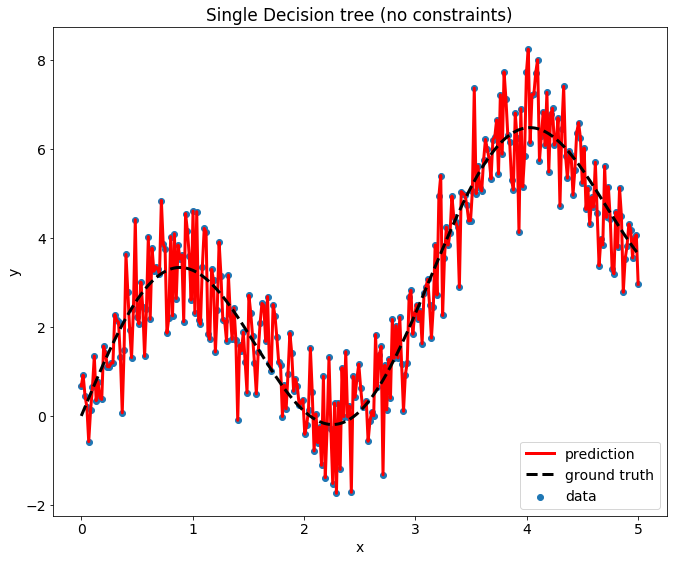

In [10]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,dt.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Single Decision tree (no constraints)')
plt.legend(loc='lower right');

In [11]:
rf = RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=5)
rf.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

# Random Forest Regressor

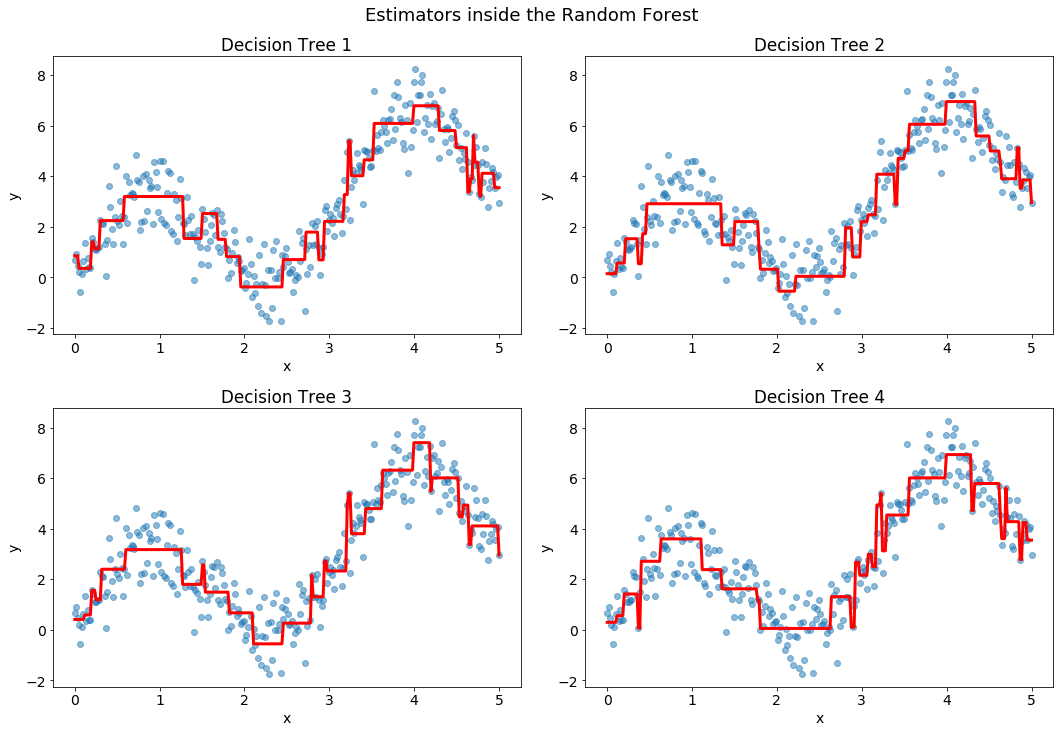

In [18]:
plt.figure(figsize=(15,10))
for i,est in enumerate(rf.estimators_[:4]):
    plt.subplot(2,2,i+1)
    plt.scatter(x,y, alpha=0.5)
    plt.plot(x,est.predict(x), 'r')
    plt.title("Decision Tree {}".format(i+1));
    plt.xlabel('x')
    plt.ylabel('y')
plt.tight_layout()
plt.suptitle('Estimators inside the Random Forest', fontsize=18, y=1.02);

# Random Forest Regressor

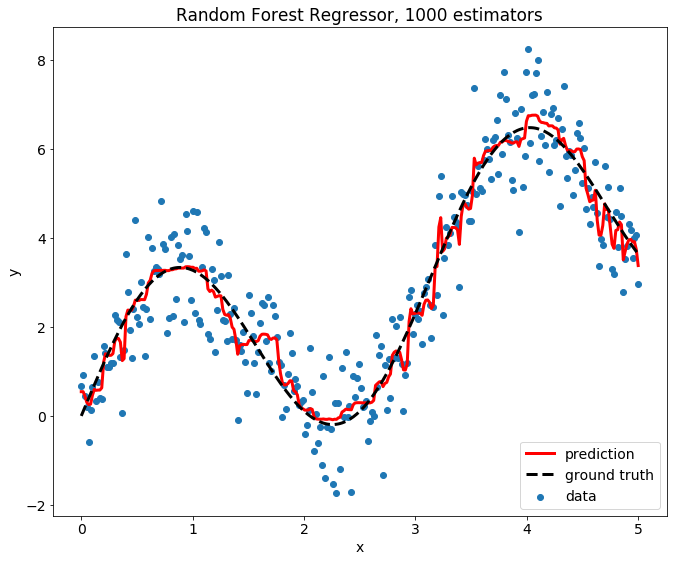

In [19]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,rf.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Random Forest Regressor, {} estimators'.format(rf.n_estimators))
plt.legend(loc='lower right');

# Moral of story?
- RF took a *strong* learner (the deep tree: high variance, prone to overfit), found a way to generate many *different* strong estimators, and averaged them to get a model with lower variance (less prone to overfit)
- Cool trick!

# Is there a cool trick for weak learners?
- A weak learner would be a "stub tree", a single decision tree with `max_depth=1`

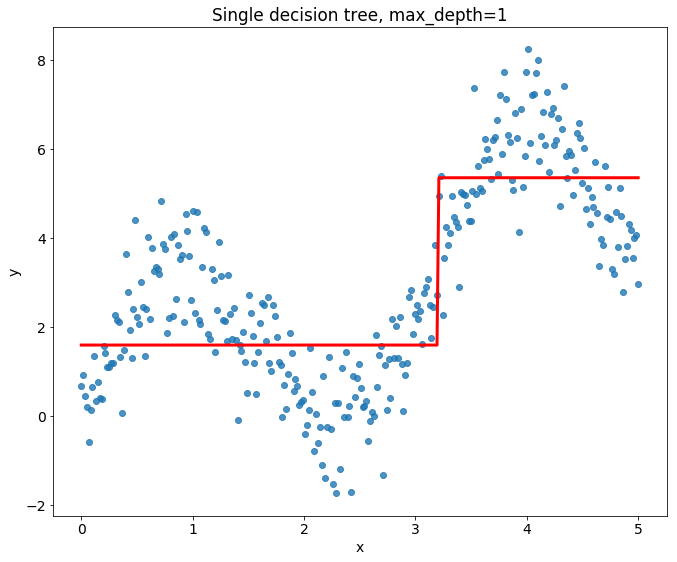

In [21]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, alpha=0.8)
dt_w = DecisionTreeRegressor(max_depth=1)
dt_w.fit(x,y)
plt.plot(x, dt_w.predict(x), 'r')
plt.title("Single decision tree, max_depth=1");
plt.xlabel('x')
plt.ylabel('y');

- Hmm, low variance, high bias, not very sensitive to "noisy" fluctuations in the data... bootstrap aggregating would be super ineffective. What can we do?

- Here is what we will do: fit another stubby tree to the _residuals_ of the first tree.

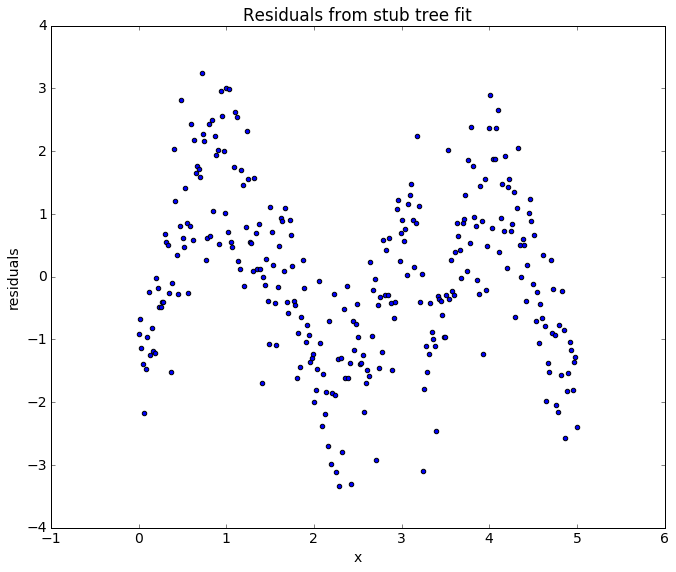

In [12]:
plt.figure(figsize=(11,9))
r_1 = y - dt_w.predict(x)
plt.scatter(x, r_1)
plt.title('Residuals from stub tree fit')
plt.xlabel('x')
plt.ylabel('residuals');

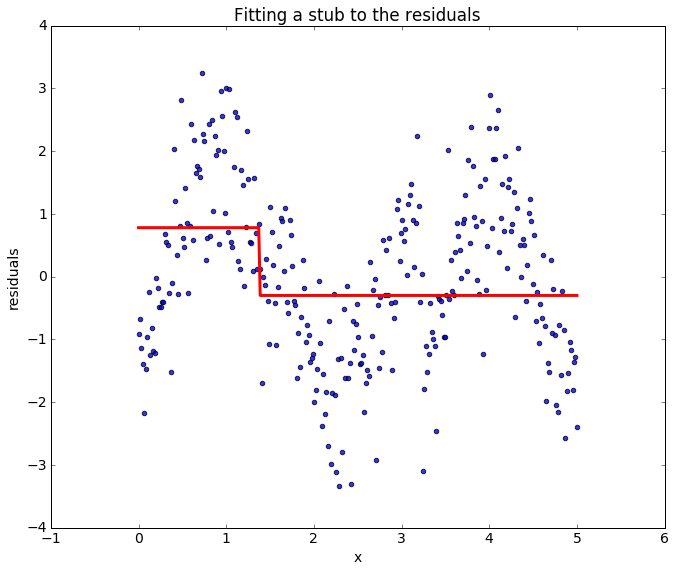

In [13]:
plt.figure(figsize=(11,9))
plt.scatter(x,r_1, alpha=0.8)
dt_w_1 = DecisionTreeRegressor(max_depth=1)
dt_w_1.fit(x,r_1)
plt.plot(x, dt_w_1.predict(x), 'r')
plt.title("Fitting a stub to the residuals");
plt.xlabel('x')
plt.ylabel('residuals');

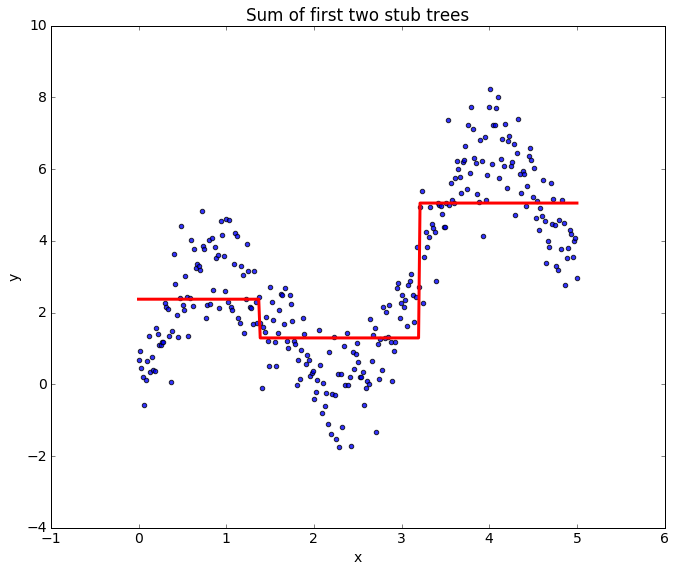

In [14]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, alpha=0.8)
plt.plot(x, dt_w.predict(x) + dt_w_1.predict(x), 'r')
plt.title("Sum of first two stub trees");
plt.xlabel('x')
plt.ylabel('y');

- Wow let's keep going! Fit a stub to the residuals from this model.

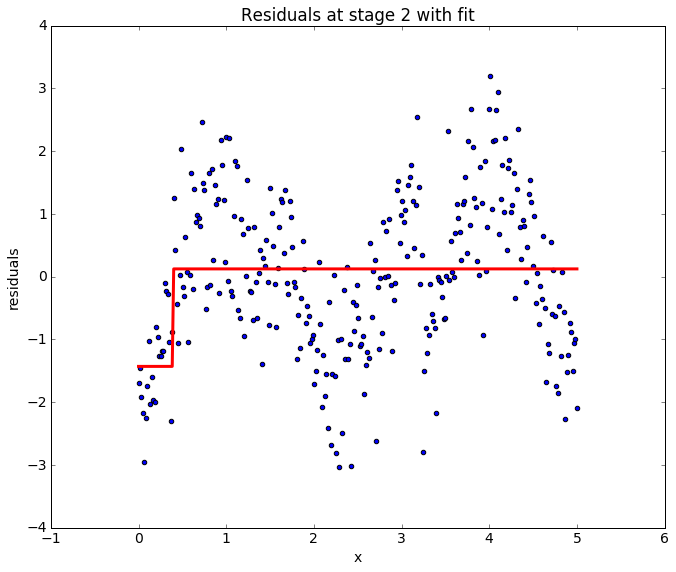

In [15]:
plt.figure(figsize=(11,9))
r_2 = y - (dt_w.predict(x) + dt_w_1.predict(x))
plt.scatter(x, r_2)
dt_w_2 = DecisionTreeRegressor(max_depth=1)
dt_w_2.fit(x,r_2)
plt.plot(x, dt_w_2.predict(x), 'r')
plt.title('Residuals at stage 2 with fit')
plt.xlabel('x')
plt.ylabel('residuals');

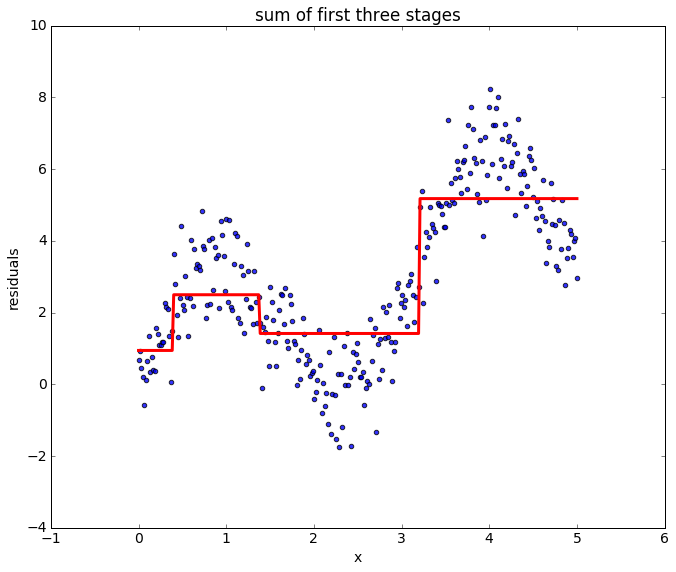

In [16]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, alpha=0.8)
plt.plot(x, dt_w.predict(x) + dt_w_1.predict(x) + dt_w_2.predict(x), 'r')
plt.title("sum of first three stages");
plt.xlabel('x')
plt.ylabel('residuals');

In [17]:
num_est = 100
gb = GradientBoostingRegressor(max_depth=1, n_estimators=num_est, learning_rate=1)
gb.fit(x,y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=1, loss='ls',
             max_depth=1, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

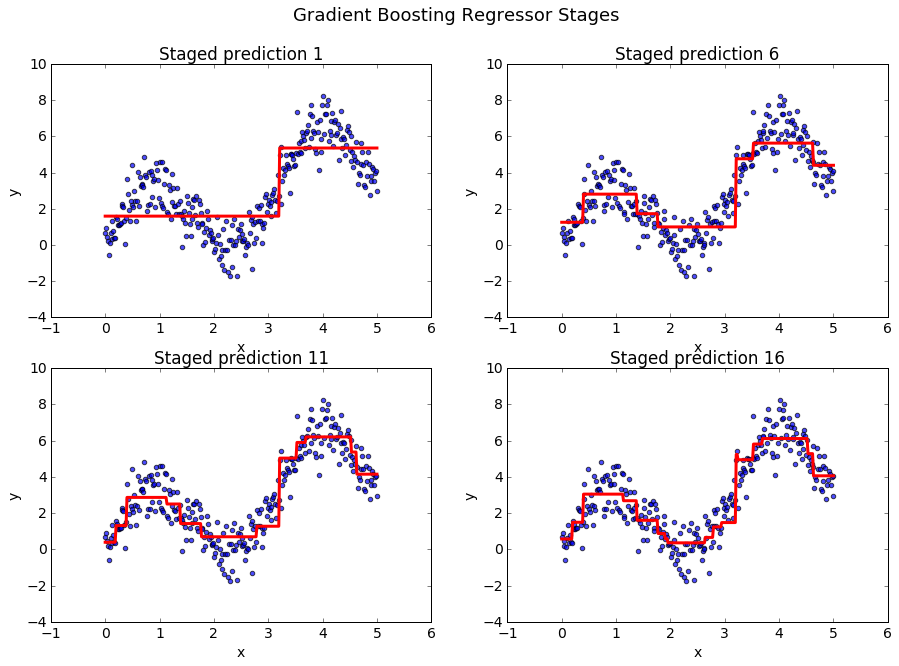

In [18]:
plt.figure(figsize=(15,10))
for i,est in enumerate(gb.staged_predict(x)):
    if not i%5:
        plt.subplot(2,2,i/5+1)
        plt.scatter(x,y, alpha=0.7)
        plt.plot(x,est, 'r')
        plt.title("Staged prediction {}".format(i+1));
        plt.xlabel('x')
        plt.ylabel('y')
    if i==15:
        break
plt.suptitle('Gradient Boosting Regressor Stages', fontsize=18);

# Gradient Boosting algorithm
- $ F_0(x) = \bar{y}$
- For $m=1$ to $M$ (number of estimators):
    - $ \tilde{y_i} = y_i - F_{m-1}(x_i)$
        - these are the residuals
    - $ f_m(x) = \underset{h_m}{\mathrm{argmin}}\sum_i(\tilde{y_i} - h_m(x_i))^2$
        - $ f_m(x)$ is the weak learner (in these examples, a stub tree) fit to the residuals $\tilde{y_i}$
    - $ F_m(x) = F_{m-1}(x) + \alpha f_m(x) $
- $\alpha$ is the *learning rate*

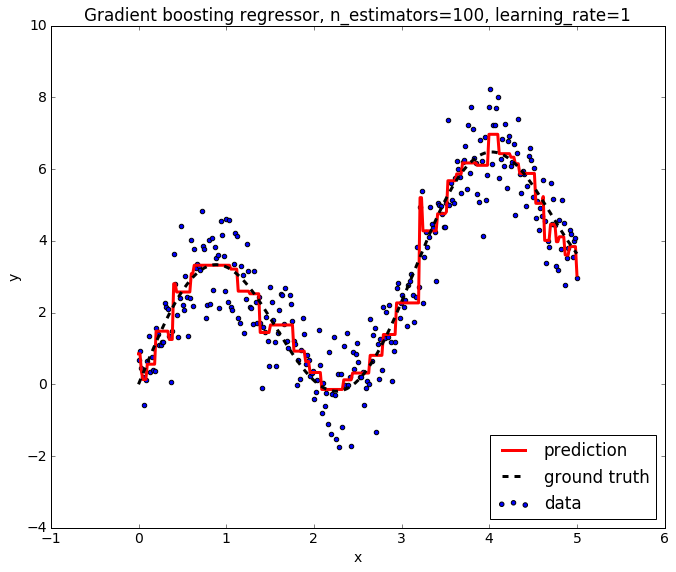

In [19]:
plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,gb.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient boosting regressor, n_estimators=100, learning_rate=1')
plt.legend(loc='lower right');

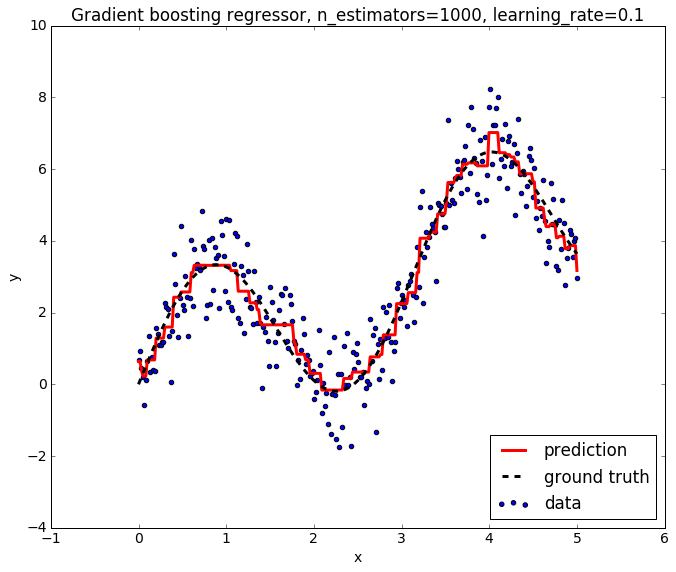

In [20]:
num_est = 1000
gb2 = GradientBoostingRegressor(max_depth=1, n_estimators=num_est, learning_rate=0.1)
gb2.fit(x,y)

plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,gb2.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient boosting regressor, n_estimators=1000, learning_rate=0.1')
plt.legend(loc='lower right');

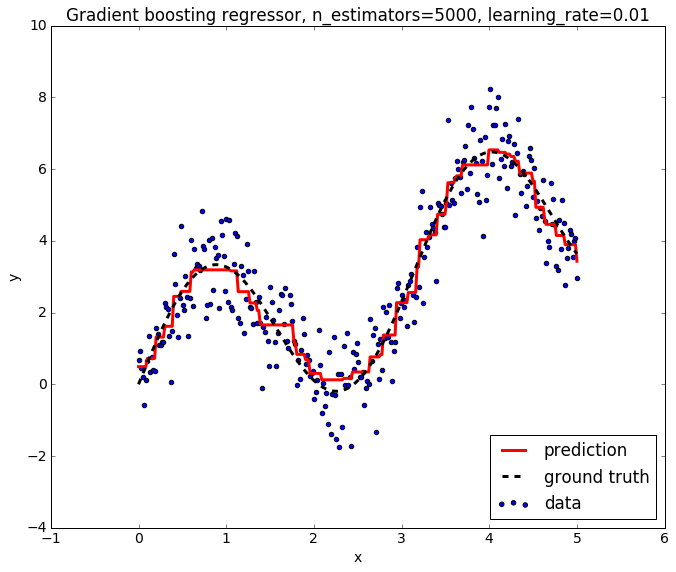

In [21]:
num_est = 5000
gb3 = GradientBoostingRegressor(max_depth=1, n_estimators=num_est, learning_rate=0.01)
gb3.fit(x,y)

plt.figure(figsize=(11,9))
plt.scatter(x,y, label='data')
plt.plot(x,gb3.predict(x), 'r', label='prediction')
plt.plot(x, y_ground, 'k--', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gradient boosting regressor, n_estimators=5000, learning_rate=0.01')
plt.legend(loc='lower right');

# GB hyperparameters
- `n_estimators` (hundreds? thousands?). Too high and you will overfit.
- `learning_rate` $\alpha$ (usually 0.1, 0.01, 0.001)
  - a smaller $\alpha$ requires more estimators
- `max_depth`: keep it low, you don't want your estimators to be too strong
- `max_features`: lowering this will also keep your trees weak
- `subsample`: only use a random fraction of the data (not bootstrapped!) at each estimator. This is stochastic gradient boosting. In sklearn the default is 1 (no subsampling), but setting it to 0.5 is highly recommended.
- Grid search!

In [22]:
def plot_train_test(est, x, y, label='', **kwargs):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2)
    est.fit(x_train, y_train)
    train_mse = []
    test_mse = []
    for train_pred, test_pred in izip(est.staged_predict(x_train), est.staged_predict(x_test)):
        train_mse.append(mse(train_pred, y_train))
        test_mse.append(mse(test_pred, y_test))
    plt.plot(train_mse, label=label+r'training mse', **kwargs )
    plt.plot(test_mse, label=label+r'test mse', **kwargs)

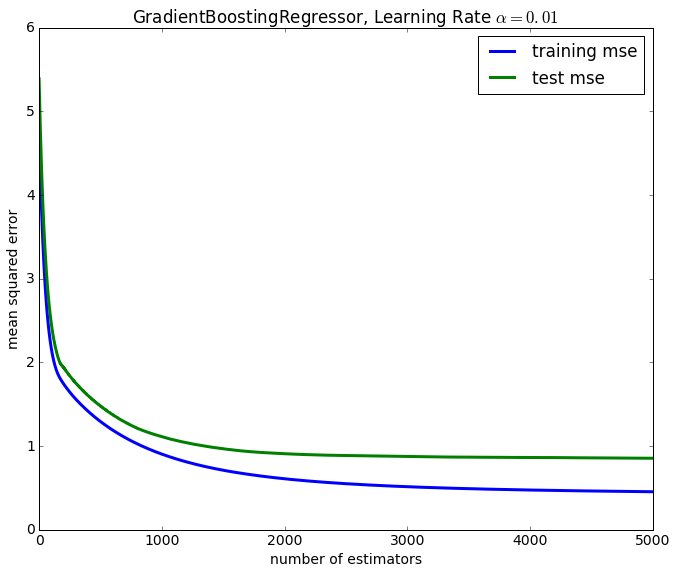

In [23]:
plt.figure(figsize=(11,9))
plot_train_test(gb3,x,y)
plt.title(r'{}, Learning Rate $\alpha={}$'.format(gb3.__class__.__name__, gb3.learning_rate))
plt.xlabel('number of estimators')
plt.ylabel('mean squared error')
plt.legend();

In [24]:
gb_s = GradientBoostingRegressor(subsample=0.5, learning_rate=0.1, n_estimators=1000, random_state=35)
gb_4 = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000)

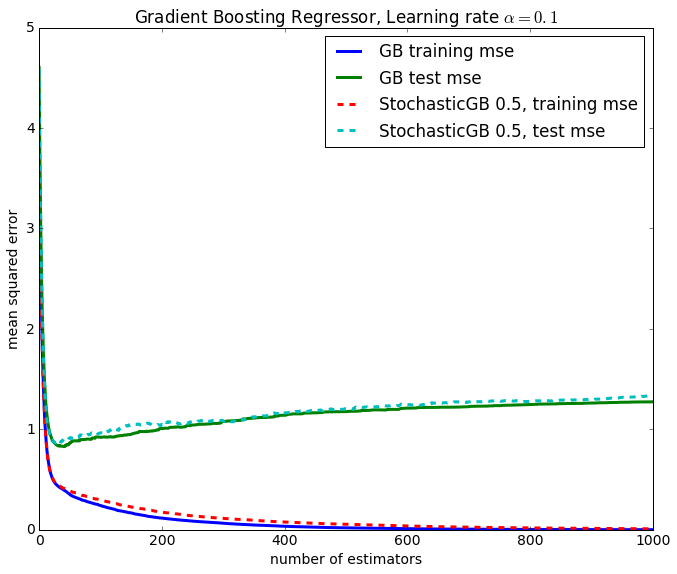

In [25]:
plt.figure(figsize=(11,9))
plot_train_test(gb_4, x, y, label='GB ')
plot_train_test(gb_s, x, y, label='StochasticGB {}, '.format(gb_s.subsample),linestyle='--')

plt.title(r'Gradient Boosting Regressor, Learning rate $\alpha=0.1$')
plt.xlabel('number of estimators')
plt.ylabel('mean squared error')
plt.legend();

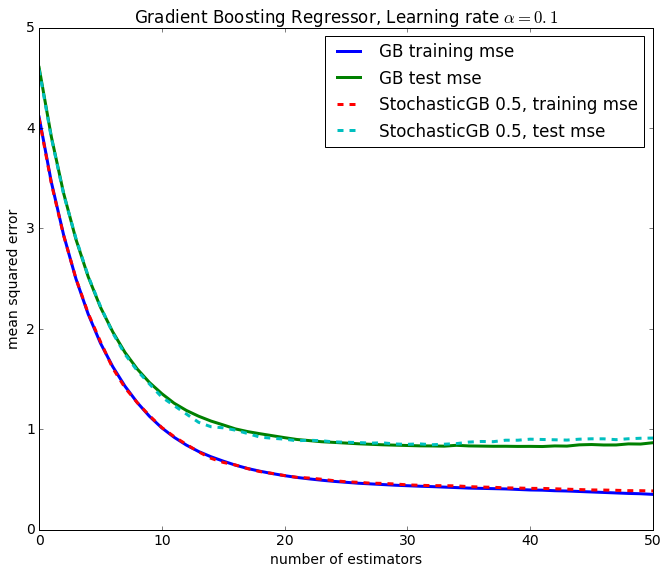

In [26]:
plt.figure(figsize=(11,9))
plot_train_test(gb_4, x, y, label='GB ')
plot_train_test(gb_s, x, y, label='StochasticGB {}, '.format(gb_s.subsample),linestyle='--')

plt.xlim((0,50))
plt.title(r'Gradient Boosting Regressor, Learning rate $\alpha=0.1$')
plt.xlabel('number of estimators')
plt.ylabel('mean squared error')
plt.legend();

# GB vs. RF
- RF is parallelizable, GB is not
- GB tends to outperform RF once tuned. 
- (see bias-variance trade-off curve on board)

In [27]:
print "GB (n_est = 1000, alpha=0.1)   3-fold cross-validated mse score: ", np.abs(np.mean(cross_val_score(gb2,x,y, scoring="mean_squared_error", n_jobs=-1)))
print "RF (n_est = 1000, max_depth=5) 3-fold cross-validated mse score: ", np.abs(np.mean(cross_val_score(rf,x,y, scoring="mean_squared_error", n_jobs=-1)))

GB (n_est = 1000, alpha=0.1)   3-fold cross-validated mse score:  3.00832787934
RF (n_est = 1000, max_depth=5) 3-fold cross-validated mse score:  3.2365410267


In [28]:
x_c, y_c = make_classification(n_features=2, n_redundant=0, random_state=41)

In [29]:
ad = AdaBoostClassifier()
ad.fit(x_c, y_c)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [30]:
# def decision_boundary(clf, X, Y, h=.02):
# """Inputs:
#         clf - a trained classifier, with a predict method
#     """
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, m_max]x[y_min, y_max].
#     x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
#     y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

#     # Put the result into a color plot
#     Z = Z.reshape(xx.shape)
#     #plt.figure(1, figsize=(4, 3))
#     plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

#     # Plot also the training points
#     plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())
#     plt.xticks(())
#     plt.yticks(())
#     #plt.show()

In [31]:
h=0.02
x_min, x_max = x_c[:, 0].min() - .5, x_c[:, 0].max() + .5
y_min, y_max = x_c[:, 1].min() - .5, x_c[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh = np.c_[xx.ravel(), yy.ravel()]

# AdaBoost Classifier
- Adaptive Boosting
- still adds together many weak estimators
- at each step, each sample point is re-weighted based on whether it was correctly classified in the previous step
- each estimator also gets a weight depending on its misclassification rate
- you can pass sample weights to a `DecisionTreeClassifier` using the `sample_weight` keyword argument of the `fit()` method

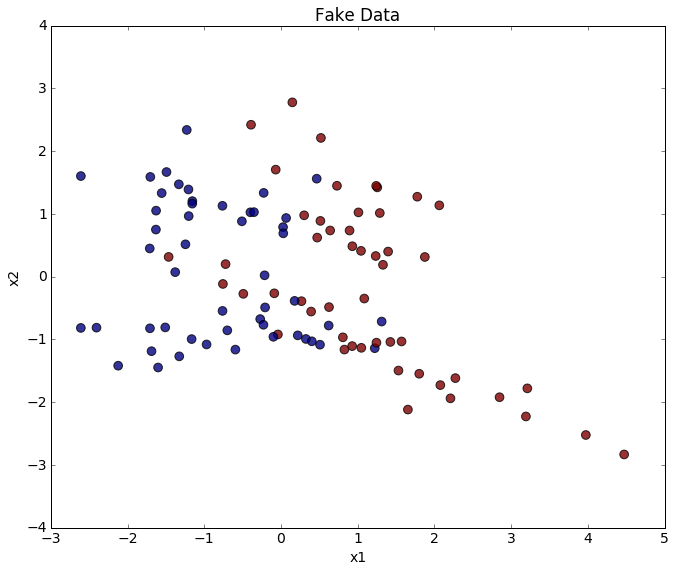

In [32]:
plt.figure(figsize=(11,9))
plt.scatter(x_c[:,0], x_c[:,1], c=y_c, alpha=0.8, s=75)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Fake Data');

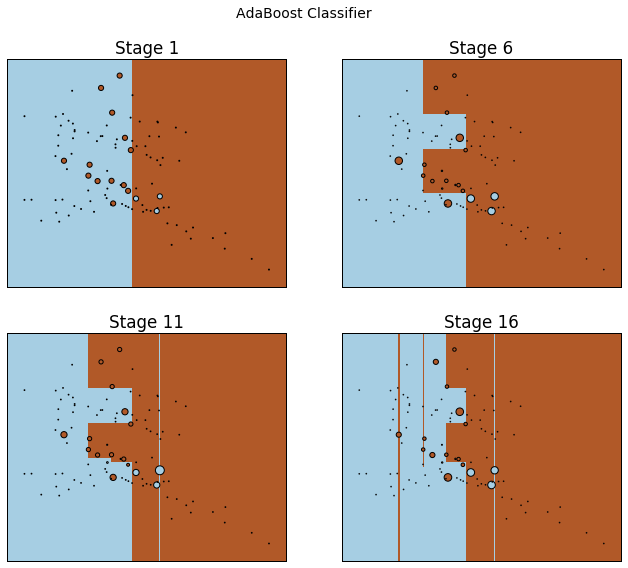

In [33]:
plt.figure(figsize=(11,9))
i = 0
weights = np.ones(x_c.shape[0])/x_c.shape[0]
for mesh_pred, pred in izip(ad.staged_predict(mesh), ad.staged_predict(x_c)):
    if not i%5:
        plt.subplot(2,2,i/5+1)
        pred_mesh = mesh_pred.reshape(xx.shape)
        plt.pcolormesh(xx, yy, pred_mesh, cmap=plt.cm.Paired)
        mask = (pred != y_c)
        error = 1.*weights[mask].sum()/weights.sum()
        alpha = np.log((1 - error)/error)
        weights *= np.exp(alpha * (mask*2 -1))
        weights /= weights.sum()
        plt.scatter(x_c[:,0], x_c[:,1], c=y_c, edgecolors='k', s=500*weights, cmap=plt.cm.Paired)
        
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title('Stage {}'.format(i+1))
    if i/5 ==3:
        break
    i += 1
plt.suptitle('AdaBoost Classifier');

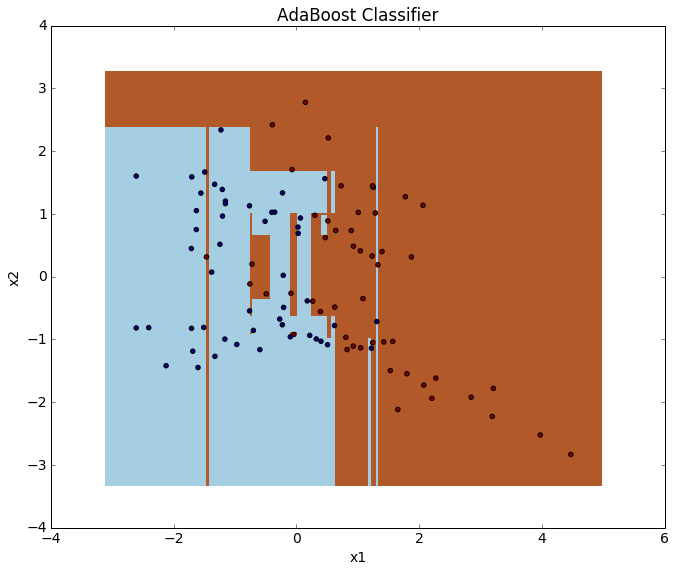

In [34]:
plt.figure(figsize=(11,9))
pred_mesh = ad.predict(mesh).reshape(xx.shape)
plt.pcolormesh(xx, yy, pred_mesh, cmap=plt.cm.Paired)
plt.scatter(x_c[:,0],x_c[:,1], c=y_c)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('AdaBoost Classifier');

# AdaBoost algorithm
- fun tweak: $y$ labels must be $\{-1, 1\}$ instead of $\{0, 1\}$
- n samples, m estimators
- initialize sample weights to $w_i = \frac{1}{n}$

# AdaBoost algorithm
- for $ k = 1, ..., m$:
    - train a weak learner $g_k(x)$ on $\{x_i, y_i\}$ using sample weights $\{w_i\}$
    - calculate tree error $\epsilon_k = \frac{\sum_i^n{w_i I(g_k(x_i)\neq y_i)}}{\sum_i^n{w_i}}$
    - set the tree weight $\alpha_k=\log\left(\frac{1 - \epsilon_k}{\epsilon_k}\right)$
    - update sample weights $w_i \rightarrow w_i \exp(-\alpha_k y_i g_k(x_i))$
    - normalize sample weights $w_i \rightarrow \frac{w_i}{\sum_i^n w_i}$
- final model $G(x) = \text{sign}\left( \sum_k^m \alpha_k g_k(x) \right)$

# AdaBoost
- it is great
- performs very well out of the box
- still gotta tune it since it can so easily overfit
- "predicted probabilities" not as clear as Random Forest's

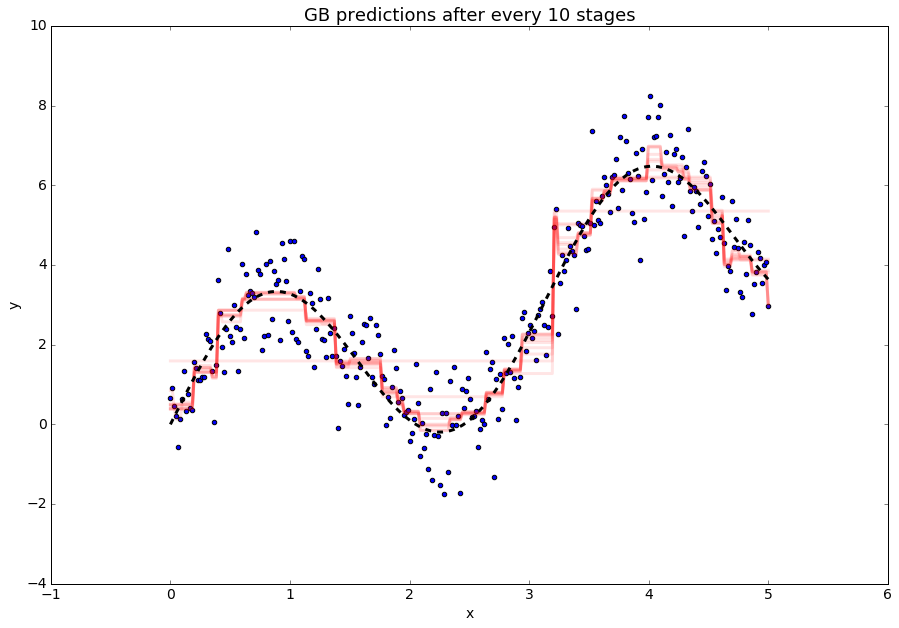

In [35]:
plt.figure(figsize=(15,10))
plt.scatter(x,y)
alphas = np.linspace(0.1, 0.9, num_est)
i = 0
for alpha,est in izip(alphas, gb.staged_predict(x)):
    if not i%10:
        plt.plot(x,est, 'r', alpha=alpha)
        plt.xlabel('x')
        plt.ylabel('y')
    i+=1
plt.plot(x, y_ground, 'k--', label='ground truth function')
plt.title('GB predictions after every 10 stages', fontsize=18);